In [4]:
from utils import *
from param import *

### Load the images into the program

In [7]:
# specify the paths to the tiff images

material_path = '/QRISdata/Q1851/Minh/RNAScope/Tiff_images_all/Tissue_1_E15/'
round1_dapi = '2020_05_05_R1_DAPI_TIFF/'
round2_dapi = '2020_05_06_R2_DAPI_TIFF'
dapi_1 = os.path.join(material_path, round1_dapi, '2020_05_05_R1_DAPI_TIFF_s1z1c4.tif')
dapi_2 = os.path.join(material_path, round2_dapi, '2020_05_06_R2_DAPI_TIFF_s1z1c3.tif')


In [8]:
# load the images and convert them into different formats  
# numpy type image
img_dapi1 = cv2.cvtColor(cv2.imread(dapi_1), cv2.COLOR_BGR2RGB)
img_dapi2 = cv2.cvtColor(cv2.imread(dapi_2), cv2.COLOR_BGR2RGB)
# convert to pil type image
pil_img_dapi1 = Image.fromarray(img_dapi1)
pil_img_dapi2 = Image.fromarray(img_dapi2)
# convert color images (3 channels) to gray scale images
dapi1_gray = pil_img_dapi1.convert('L')
dapi2_gray = pil_img_dapi2.convert('L')
# convert pil images to itk image
dapi1_gray_itk = get_itk_from_pil(dapi1_gray)
dapi2_gray_itk = get_itk_from_pil(dapi2_gray)
fixed_img = dapi1_gray_itk
moving_img = dapi2_gray_itk

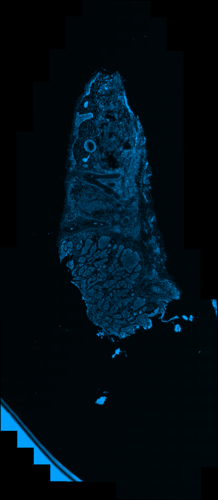

In [14]:
thumbnail(pil_img_dapi1, (500,500))

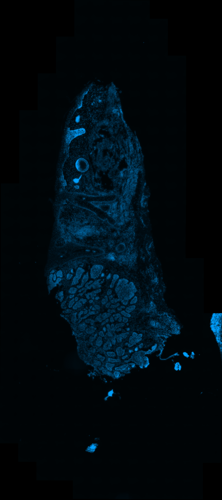

In [15]:
thumbnail(pil_img_dapi2, (500,500))

### Create a SITK image registration method
#### First we run affine transformations to map one image to the other to generate the affine map between two images


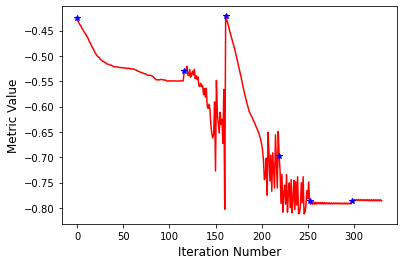

Affine metric value: -0.7840434728213133
Affine Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 33.


In [9]:
initial_transform = sitk.CenteredTransformInitializer(fixed_img, moving_img, sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
affine_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
affine_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=75)
affine_method.SetMetricSamplingStrategy(affine_method.RANDOM)
affine_method.SetMetricSamplingPercentage(0.15)

affine_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
affine_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=300, convergenceMinimumValue=1e-6, convergenceWindowSize=20)
affine_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.      
affine_method.SetShrinkFactorsPerLevel(shrinkFactors = [16,8,4,3,2,1])
affine_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[10,4,3,2,1,0])
affine_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
affine_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
affine_method.AddCommand(sitk.sitkStartEvent, start_plot)
affine_method.AddCommand(sitk.sitkEndEvent, end_plot)
affine_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
affine_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(affine_method))

affine_transform = affine_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_img, sitk.sitkFloat32))

print('Affine metric value: {0}'.format(affine_method.GetMetricValue()))
print('Affine Optimizer\'s stopping condition, {0}'.format(affine_method.GetOptimizerStopConditionDescription()))

In [10]:
moving_resampled_affine = sitk.Resample(moving_img, fixed_img, affine_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled_affine)))

0.4776362595123825

(7859, 17989)
(17989, 7859, 3)


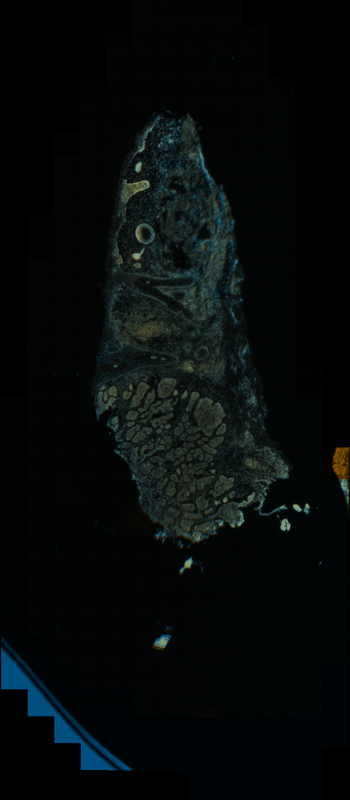

In [12]:
moving_rgb_affine = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, affine_transform)
print(moving_rgb_affine.size)
change_color_mv_rgb_final = np.array(moving_rgb_affine)
print(change_color_mv_rgb_final.shape)
# we change the color channel order of one image so that we see the differences more clear
converted_color = cv2.cvtColor(change_color_mv_rgb_final, cv2.COLOR_BGR2RGB)
foreground = Image.fromarray(converted_color)
background = pil_img_dapi1
# overlay two images into one 
overlayed_imgs_affine = overlay_pil_imgs(background=background, foreground=foreground, alpha=0.5)
thumbnail(overlayed_imgs_affine, size = (800,800))

#### Second we run the b-spline transform to smooth out the unaligned corners between two 

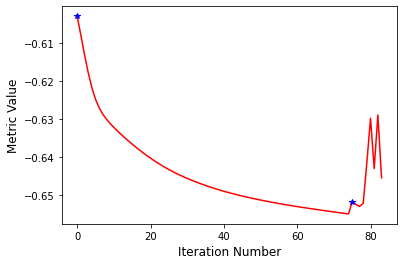

BSpline metric value: -0.6291345334310641
BSpline Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [16]:
bspline_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
bspline_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
bspline_method.SetMetricSamplingStrategy(bspline_method.RANDOM)
bspline_method.SetMetricSamplingPercentage(0.15)

bspline_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
bspline_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=75, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
bspline_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
bspline_method.SetShrinkFactorsPerLevel(shrinkFactors = [2,1])
bspline_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1,0])
bspline_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
transformDomainMeshSize = [8]*moving_resampled_affine.GetDimension()
initial_transform = sitk.BSplineTransformInitializer(fixed_img, transformDomainMeshSize)
bspline_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
bspline_method.AddCommand(sitk.sitkStartEvent, start_plot)
bspline_method.AddCommand(sitk.sitkEndEvent, end_plot)
bspline_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
bspline_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(bspline_method))

bspline_transform = bspline_method.Execute(sitk.Cast(fixed_img, sitk.sitkFloat32), 
                                               sitk.Cast(moving_resampled_affine, sitk.sitkFloat32))

print('BSpline metric value: {0}'.format(bspline_method.GetMetricValue()))
print('BSpline Optimizer\'s stopping condition, {0}'.format(bspline_method.GetOptimizerStopConditionDescription()))

In [17]:
moving_resampled_final = sitk.Resample(moving_resampled_affine, fixed_img, bspline_transform, 
                                 sitk.sitkLinear, 0.0, moving_img.GetPixelID())
calculate_mutual_info(np.array(dapi1_gray), np.array(get_pil_from_itk(moving_resampled_final)))


0.5006101396031197

(7859, 17989)
(17989, 7859, 3)


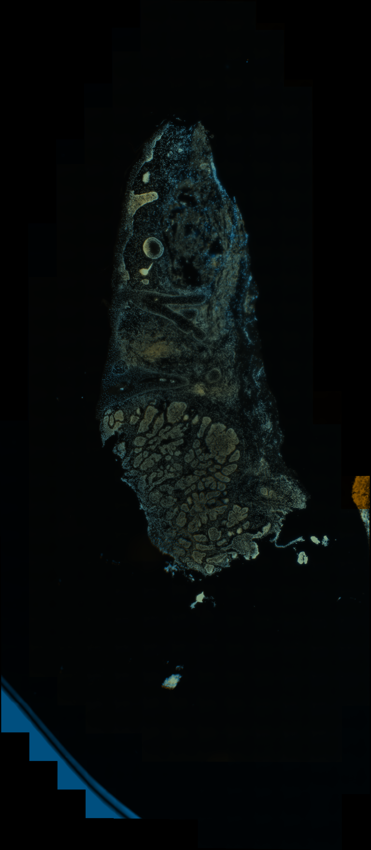

In [18]:
moving_rgb_affine = sitk_transform_rgb(pil_img_dapi2, pil_img_dapi1, affine_transform)
moving_rgb_final = sitk_transform_rgb(moving_rgb_affine, pil_img_dapi1, bspline_transform)

print(moving_rgb_final.size)
change_color_mv_rgb_final = np.array(moving_rgb_final)
print(change_color_mv_rgb_final.shape)
converted_color = cv2.cvtColor(change_color_mv_rgb_final, cv2.COLOR_BGR2RGB)
foreground = Image.fromarray(converted_color)
background = pil_img_dapi1
overlayed_imgs_4 = overlay_pil_imgs(background=background, foreground=foreground, alpha=0.5)
thumbnail(overlayed_imgs_4, size = (850,850))

In [19]:
# The combination of two transformation methods increase the mutual score between to image 

In [20]:
# save the transform result to file for later use
sitk.WriteTransform(affine_transform, 'BCC_Skin1_r1_registration_affine_transform.tfm')
sitk.WriteTransform(bspline_transform, 'BCC_Skin1_r2_registration_bspline_transform.tfm')

## For other images, the same process can be used. 